In [1]:
import pandas as pd
import numpy as np

## Data

The datasets consist of several medical predictor (independent) variables and one target (dependent) variable, Outcome. Independent variables include the number of pregnancies the patient has had, their BMI, insulin level, age, and so on.

In [2]:
pima = pd.read_csv('../Pima_dataset/diabetes.csv')

In [3]:
pima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [10]:
(pima[pima["Outcome"]==1].shape[0], pima[pima["Outcome"]==0].shape[0])

(268, 500)

* Pregnancies: Number of times pregnant
* Glucose: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
* BloodPressure: Diastolic blood pressure (mm Hg)
* SkinThickness: Triceps skin fold thickness (mm)
* Insulin: 2-Hour serum insulin (mu U/ml)
* BMI: Body mass index (weight in kg/(height in m)^2)
* DiabetesPedigreeFunction: Diabetes pedigree function (a function which scores likelihood of diabetes based on family history)
* Age: Age (years)
* Outcome: Class variable (0 or 1) 268 of 768 are 1, the others are 0

## Data Cleaning / Data Imputation

https://towardsdatascience.com/machine-learning-workflow-on-diabetes-data-part-01-573864fcc6b8

https://medium.com/analytics-vidhya/analyzing-pima-indian-diabetes-dataset-36d02a8a10e5

In [4]:
pima.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [5]:
# Count number of zeros in all columns of Dataframe
for column_name in pima.columns:
    column = pima[column_name]
    # Get the count of Zeros in column 
    count = (column == 0).sum()
    print('Count of zeros in column', column_name, 'is:', count)

Count of zeros in column Pregnancies is: 111
Count of zeros in column Glucose is: 5
Count of zeros in column BloodPressure is: 35
Count of zeros in column SkinThickness is: 227
Count of zeros in column Insulin is: 374
Count of zeros in column BMI is: 11
Count of zeros in column DiabetesPedigreeFunction is: 0
Count of zeros in column Age is: 0
Count of zeros in column Outcome is: 500


##### Column values that can not be zero:
* Glucose: Even after fasting glucose levels would not be as low as zero. Therefore zero is an invalid reading
* BloodPressure: A living person cannot have a diastolic blood pressure of zero. 
* Skin thickness: For normal people, skin fold thickness can’t be less than 10 mm better yet zero.
* Insulin: In a rare situation a person can have zero insulin but by observing the data, we can find that there is a total of 374 counts.
* BMI: Should not be 0 or close to zero unless the person is really underweight which could be life-threatening.

1. Ignore/remove these cases: This is not actually possible in most cases because that would mean losing valuable information. And in this case “skin thickness” and “insulin” columns mean to have a lot of invalid points. But it might work for “BMI”, “glucose ”and “blood pressure” data points.
2. Put average/mean values: This might work for some data sets, but in our case putting a mean value to the blood pressure column would send a wrong signal to the model.
3. Avoid using features: It is possible to not use the features with a lot of invalid values for the model. This may work for “skin thickness” but it's hard to predict that.

In [6]:
pima["Glucose"].replace(0, np.NaN, inplace=True)
pima["BloodPressure"].replace(0, np.NaN, inplace=True)
pima["SkinThickness"].replace(0, np.NaN, inplace=True)
pima["Insulin"].replace(0, np.NaN, inplace=True)
pima["BMI"].replace(0, np.NaN, inplace=True)

In [7]:
pima.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [8]:
X = pima.drop(["Outcome"], axis=1)
y = pima["Outcome"]

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)

In [10]:
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [11]:
clf = RandomForestClassifier(random_state=0)

In [12]:
N_SPLITS = 5

### Impute missing values with mean

In [13]:
imputer = SimpleImputer(missing_values=np.nan, strategy="mean", add_indicator=True)
estimator = make_pipeline(imputer, clf)
mean_impute_scores = cross_val_score(estimator, X, y, cv=N_SPLITS)

In [14]:
mean_impute_scores.mean()

0.7565401918343094

### KNN Imputation
Imputation for completing missing values using k-Nearest Neighbors.

Each sample’s missing values are imputed using the mean value from n_neighbors nearest neighbors found in the training set. Two samples are close if the features that neither is missing are close.

Another critical point here is that the KNN Imptuer is a distance-based imputation method and it requires us to normalize our data. Otherwise, the different scales of our data will lead the KNN Imputer to generate biased replacements for the missing values. For simplicity, we will use Scikit-Learn’s MinMaxScaler which will scale our variables to have values between 0 and 1.

https://machinelearningmastery.com/knn-imputation-for-missing-values-in-machine-learning/

In [15]:
# neighbors = [1, 3, 5, 7, 9, 11, 13, 15]
neighbors = range(1,16)
impute_scores = []

In [16]:
for n in neighbors:
    imputer = KNNImputer(missing_values=np.nan, n_neighbors=n, add_indicator=True)
    estimator = make_pipeline(imputer, clf)
    scores = cross_val_score(estimator, X, y, cv=N_SPLITS)
    impute_scores.append(scores)
    print('n=%s, %.3f (%.3f)' % (n, np.mean(scores), np.std(scores)))

n=1, 0.764 (0.029)
n=2, 0.757 (0.020)
n=3, 0.757 (0.031)
n=4, 0.764 (0.033)
n=5, 0.764 (0.035)
n=6, 0.763 (0.026)
n=7, 0.766 (0.028)
n=8, 0.757 (0.027)
n=9, 0.776 (0.040)
n=10, 0.763 (0.025)
n=11, 0.764 (0.035)
n=12, 0.772 (0.032)
n=13, 0.768 (0.033)
n=14, 0.775 (0.031)
n=15, 0.768 (0.032)


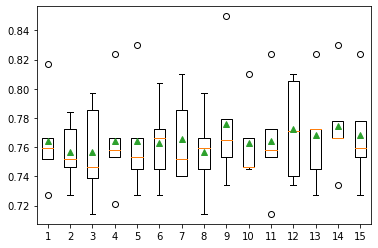

In [17]:
# plot model performance for comparison
plt.boxplot(impute_scores, labels=neighbors, showmeans=True)
plt.show()

In [18]:
from sklearn.impute import KNNImputer

# define imputer
imputer = KNNImputer(n_neighbors=9, weights='uniform', metric='nan_euclidean')

# fit on the dataset
X_impute = imputer.fit_transform(X)

In [19]:
X_impute_df = pd.DataFrame(X_impute, columns=X.columns)

In [20]:
X_impute_df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

In [21]:
pima_impute = pd.concat([X_impute_df, y], axis=1)

In [22]:
# n=4, 0.772 (0.027)
# pima_impute.to_csv('pima_impute_scaled.csv', index=False)
# n=9, 0.776 (0.040)
pima_impute.to_csv('../Pima_dataset/pima_impute.csv', index=False)

In [23]:
pima_impute

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148.0,72.0,35.000000,211.666667,33.6,0.627,50.0,1
1,1.0,85.0,66.0,29.000000,67.444444,26.6,0.351,31.0,0
2,8.0,183.0,64.0,25.888889,189.000000,23.3,0.672,32.0,1
3,1.0,89.0,66.0,23.000000,94.000000,28.1,0.167,21.0,0
4,0.0,137.0,40.0,35.000000,168.000000,43.1,2.288,33.0,1
...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.000000,180.000000,32.9,0.171,63.0,0
764,2.0,122.0,70.0,27.000000,163.444444,36.8,0.340,27.0,0
765,5.0,121.0,72.0,23.000000,112.000000,26.2,0.245,30.0,0
766,1.0,126.0,60.0,32.222222,147.444444,30.1,0.349,47.0,1
